In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import polyval, polyfit
from astropy.stats import sigma_clip

### external codes
from redTools import *
from Kcorrect import *
from linear_mcmc import *
####################################### Set Axes
def set_axes(ax_list, xlim, ylim):
    for ax in ax_list:
        
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
########################################################### Begin

inFile  = 'ESN_HI_catal.csv'   # input catalog
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

## purifying input data
index, = np.where(table['Sba']>0.01)
table = trim(table, index)

index, = np.where(table['Wba']>0.01)
table = trim(table, index)

Sba = table['Sba']  # SDSS b/a
Wba = table['Wba']  # WISE b/a

dWba = np.sqrt((0.1/6./table['R50_w1'])**2)*(1+table['Wba']**2)
dSba = np.sqrt((0.1/6./table['R50_r'])**2)*(1+table['Sba']**2)

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


## SDSS vs. WISE axial ratios

Since WISE images have a larger point spread function (PSF) compared to those of SDSS, users might have chosen larger axial ratios *(b/a)* to ease up the photometry of WISE images. *a* and *b* are semi-major and semi-minor axes of the elliptical photometry aperture. The larger the PSF is the larger *b* gets relative to *a*.
If galaxies are more face-on, i.e. larger *b/a*, the PSF effect gets smaller, since the PSF usually has a round Gaussian shape. As seen in the below diagram, the axial ratio of circular galaxies are less affected by PSF and normally the same apertures are used for both SDSS and WISE photometry.  

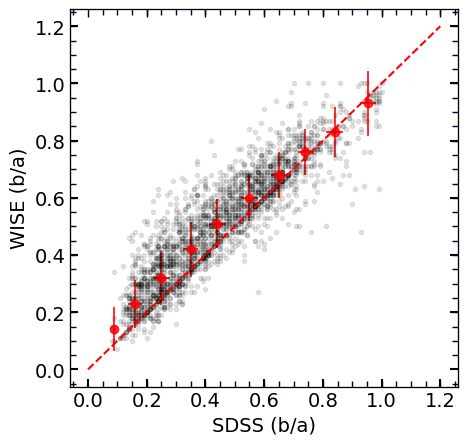

In [2]:
fig = py.figure(figsize=(5, 5), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(Sba,Wba, 'k.', alpha=0.1)  # black points
ax.plot([0,1.2],[0,1.2], 'r--')    # equality red line
ax.set_xlabel('SDSS (b/a)', size=14)
ax.set_ylabel('WISE (b/a)', size=14)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)


for i in np.arange(0,1,0.1):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.1:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        ## red points
        ax.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)


In [3]:
## function definition to reject outliers
def sigmaClip(X, Y, sigma=2, iters=5, range_=[0,1,0.05]):
    x_ = []
    y_ = []

    x_ = np.asarray(x_)
    y_ = np.asarray(y_)
    
    a = range_[0]
    b = range_[1]
    d = range_[2]

    for i in np.arange(a,b,d):

        x = []
        y = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+d:
                x.append(xi)
                y.append(Y[ii])
        if len(x)>0:
            y = np.asarray(y)
            x = np.asarray(x)
            filtered_data = sigma_clip(y, sigma=sigma, iters=iters, copy=False)
            y = filtered_data.data[np.logical_not(filtered_data.mask)]
            x = x[np.logical_not(filtered_data.mask)]

            x_ = np.concatenate((x_, x))
            y_ = np.concatenate((y_, y))
    return x_, y_


0.8541385069691012 0.12400929994929492


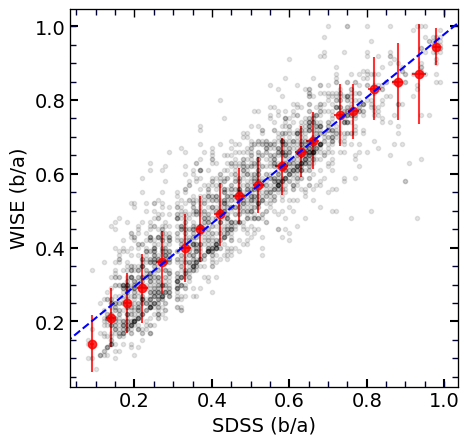

In [4]:
## Getting rid of outliers bin by bin
Sba_, Wba_ = sigmaClip(Sba, Wba, sigma=4, iters=5)

fig = py.figure(figsize=(5, 5), dpi=100)  
ax = fig.add_subplot(111)
ax.plot(Sba_,Wba_, 'k.', alpha=0.1)
#plt.plot([0,1.2],[0,1.2], 'r--')
ax.set_xlabel('SDSS (b/a)', size=14)
ax.set_ylabel('WISE (b/a)', size=14)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)

for i in np.arange(0,1,0.05):
    
    x = []
    y = []
    for ii in range(len(Sba_)):
        xi = Sba_[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Wba_[ii])
    if len(x)>0:
        ax.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

############################################# 
a0, b0  = np.polyfit(Sba_, Wba_, 1)
x = np.linspace(0,1.2,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################

print a0,b0

(0.08, 2)

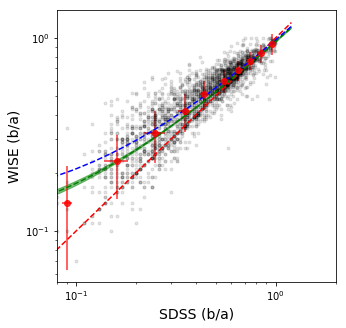

In [5]:
fig = plt.figure(figsize=(5, 5))
plt.plot(Sba,Wba, 'k.', alpha=0.1)  # black points
plt.plot([0,1.2],[0,1.2], 'r--')    # equality red line
plt.xlabel('SDSS (b/a)', size=14)
plt.ylabel('WISE (b/a)', size=14)

M,B,samples=linMC(Sba,Wba, dSba, dWba)
m = M[0] ; me=0.5*(M[1]+M[2])
b = B[0] ; be=0.5*(B[1]+B[2])
x_ = np.linspace(0,1.2,100)
y_, yu, yl = linSimul(samples, x_, size=500)

plt.fill_between(x_, y_+2*yu, y_-2*yl, color='g', alpha=0.5, edgecolor="none")
plt.plot(x_, m*x_+b, 'g--') 

for i in np.arange(0,1,0.1):
    
    x = []
    y = []
    for ii in range(len(Sba)):
        xi = Sba[ii]
        if xi>=i and xi<i+0.1:
            x.append(xi)
            y.append(Wba[ii])
    if len(x)>0:
        ## red points
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)


############################################# 
a0, b0  = np.polyfit(Sba, Wba, 1)
x = np.linspace(0,1.2,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################

plt.xscale('log')
plt.yscale('log')
plt.xlim([0.08,2])

## Comparing Half light Radii (R<sub>e</sub>)

This is an attempt to estimate the *W1* half-light radii from the *i* band measurments. 
Bulges of spiral galaxies are more luminous at larger wavelengths because they are formed by red and dead stars which appear to be yellower/redder. Therefore, at larger wavelengths we expect half-light radii to be smaller due to the more flux contribution of bulge.

Text(0,0.5,'$R_e$ WISE [arcmin]')

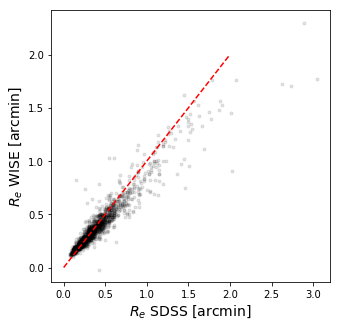

In [6]:
### Ri is the infrared half light radius
### Ro is the optical half light radius

#Ri = (table['R50_w1']+table['R50_w2'])/2.
Ri = table['R50_w1']
#Ro = (table['R50_g']+table['R50_r']+table['R50_i'])/3.
Ro = table['R50_i']
      
fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE [arcmin]', size=14)

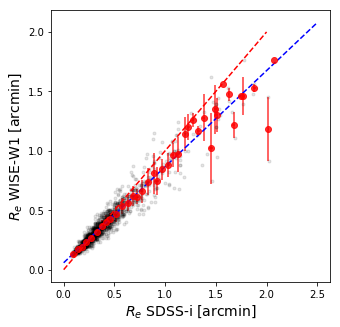

In [7]:
Ro, Ri = sigmaClip(Ro, Ri, sigma=3, iters=5, range_=[0,2.5,0.1])

fig = plt.figure(figsize=(5, 5))
plt.plot(Ro,Ri, 'k.', alpha=0.1)
plt.plot([0,2],[0,2], 'r--')
plt.xlabel('$R_e$'+' SDSS-i [arcmin]', size=14)
plt.ylabel('$R_e$'+' WISE-W1 [arcmin]', size=14)

for i in np.arange(0,2.5,0.05):
    
    x = []
    y = []
    for ii in range(len(Ro)):
        xi = Ro[ii]
        if xi>=i and xi<i+0.05:
            x.append(xi)
            y.append(Ri[ii])
    if len(x)>0:
        plt.errorbar(np.median(x), np.median(y), yerr=np.std(y), xerr=np.std(x), fmt='o', color='red', alpha=0.8)

#############################################
a0, b0  = np.polyfit(Ro, Ri, 1)
x = np.linspace(0,2.5,50)
y = a0*x+b0
plt.plot(x, y, 'b--')
#############################################

In [8]:
import numpy as np
from matplotlib import rcParams
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
import corner

rcParams["font.size"] = 16
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"



ndim, nsamples = 4, 50000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape([4 * nsamples // 5, ndim])
mean = 4*np.random.rand(ndim)
data2 = (mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape([nsamples // 5, ndim]))
samples = np.vstack([data1, data2])

# corner.corner(samples, color='k', truth_color='r', quantiles=[0.16, 0.84], show_titles=True, 
#                        fill_contours=True, plot_density=True,fontsize=16,
#                        scale_hist=False,space=0, truths=[0.31,0.23,0.32,0.03], 
#                        levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
#                        labels=["$c$", "$d$",r"$\alpha$", r"$\beta$"], title_kwargs={"fontsize":16},
#                        )
xs = samples

x = xs[:,0]
y = xs[:,1]
range = [[x.min(), x.max()], [y.min(), y.max()]]
H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=20, range=list(map(np.sort, range)))
A = np.where(H==H.max())
print A[0][0], X[A[0][0]]
        
x = xs[:,0]
y = xs[:,2]
range = [[x.min(), x.max()], [y.min(), y.max()]]
H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=20, range=list(map(np.sort, range)))
A = np.where(H==H.max())
print A[0][0], X[A[0][0]]

x = xs[:,0]
y = xs[:,3]
range = [[x.min(), x.max()], [y.min(), y.max()]]
H, X, Y = np.histogram2d(x.flatten(), y.flatten(), bins=20, range=list(map(np.sort, range)))
A = np.where(H==H.max())
print A[0][0], X[A[0][0]]


6 -0.6683994474835053
7 -0.14349004431567725
7 -0.14349004431567725


/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  from ipykernel import kernelapp as app


Text(0,0.5,'$R_e$ WISE w1-band [arcmin]')

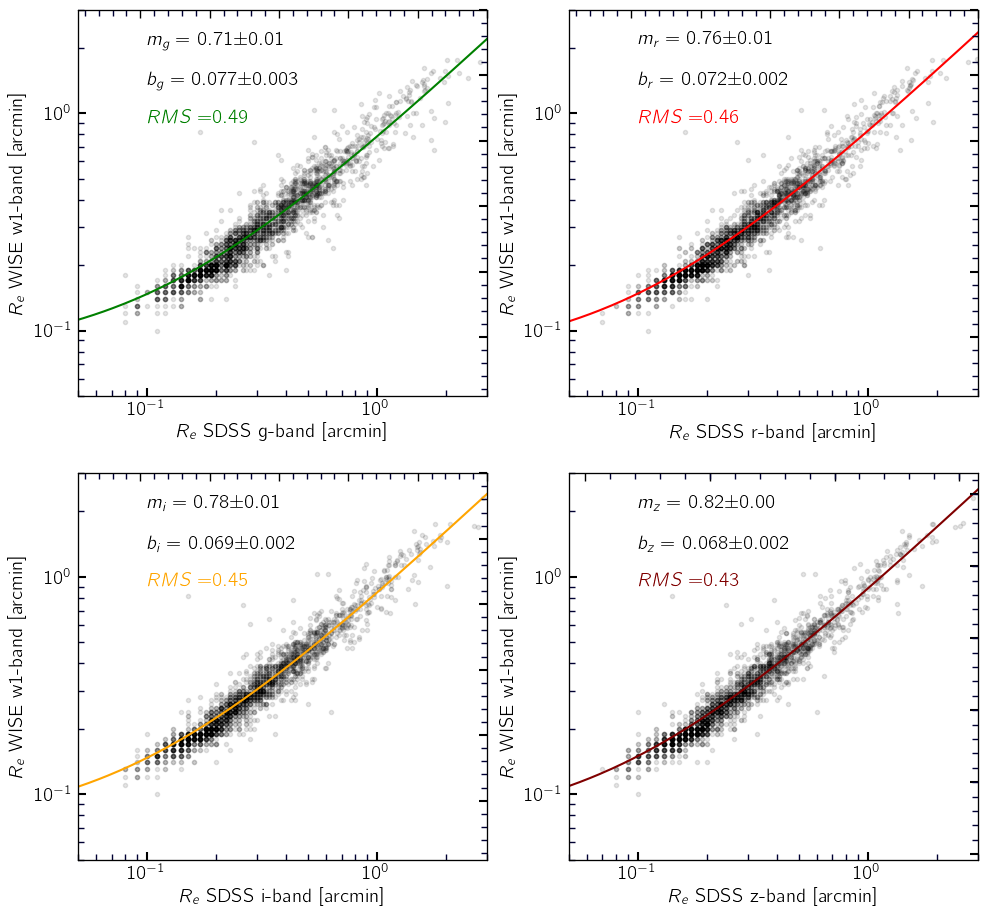

In [12]:
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
## defining the linear fit
def linfit(x, m, b):
    return m * x + b

def rms(x):
    return np.sqrt(np.mean(x**2))



########################################################### Begin

inFile  = 'ESN_HI_catal.csv'   # input catalog
table   = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

table = extinctionCorrect(table)
table = Kcorrection(table)

## purifying input data
index, = np.where(table['Sba']>0.01)
table = trim(table, index)

index, = np.where(table['Wba']>0.01)
table = trim(table, index)

index, = np.where(table['R50_g']>0)
table = trim(table, index)

index, = np.where(table['R50_r']>0)
table = trim(table, index)

index, = np.where(table['R50_i']>0)
table = trim(table, index)

index, = np.where(table['R50_z']>0)
table = trim(table, index)

index, = np.where(table['R50_w1']>0)
table = trim(table, index)

Sba = table['Sba']  # SDSS b/a
Wba = table['Wba']  # WISE b/a
Re_g = table['R50_g'] #half light radius for different bands
Re_r = table['R50_r']
Re_i = table['R50_i']
Re_z = table['R50_z']
Re_w1 = table['R50_w1']
Re_w2 = table['R50_w2']
Re_i_z = (1./2)*(Re_i + Re_z) #i+z half light radius

fit_g, cov_g = curve_fit(linfit, Re_g, Re_w1, p0=[1, 2])
fit_r, cov_r = curve_fit(linfit, Re_r, Re_w1, p0=[1, 2])
fit_i, cov_i = curve_fit(linfit, Re_i, Re_w1, p0=[1, 2])
fit_z, cov_z = curve_fit(linfit, Re_z, Re_w1, p0=[1, 2])

logFit_g, logcov_g = curve_fit(linfit, np.log10(Re_g), np.log10(Re_w1), p0=[1, 2])
logFit_r, logcov_r = curve_fit(linfit, np.log10(Re_r), np.log10(Re_w1), p0=[1, 2])
logFit_i, logcov_i = curve_fit(linfit, np.log10(Re_r), np.log10(Re_w1), p0=[1, 2])
logFit_z, logcov_z = curve_fit(linfit, np.log10(Re_z), np.log10(Re_w1), p0=[1, 2])

#print 'g: ', fit_g, cov_g
#print 'r: ', fit_r, cov_r
#print 'i: ', fit_i, cov_i
#print 'z: ', fit_z, cov_z

#a0, b0 = np.polyfit(Re_g, Re_w1, 1)

x = np.linspace(0.02,3,1000)

fig = py.figure(figsize=(10, 10), dpi=100)    
fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.95, bottom=0.10, left=0.08, right=0.98) 
gs = gridspec.GridSpec(2, 2, height_ratios=[1,1]) 
p = 0

########
ax = plt.subplot(gs[p]) ; p+=1
ax.scatter(Re_g, Re_w1, c='k', alpha=0.1, marker='.') # black points
#ax.plot(x, 10**(logFit_g[0]*np.log10(x)+logFit_g[1]), 'blue')
ax.plot(x, fit_g[0]*x+fit_g[1], 'g', label='Linear Trend')

ax.text(0.1,2., '$m_g=$ '+'%.2f'%fit_g[0]+r'$\pm$'+'%.2f'%np.sqrt(cov_g[0][0]), fontsize=14, color='k')
ax.text(0.1,1.3, r'$b_g=$ '+'%.3f'%fit_g[1]+r'$\pm$'+'%.3f'%np.sqrt(cov_g[1][1]), fontsize=14, color='k')
ax.text(0.1,0.9, '$RMS=$'+'%.2f'%rms(Re_g), fontsize=14, color='g')
#ax.text(0.1,0.6, '$RMS=$'+'%.2f'%rms(np.log10(Re_g)), fontsize=14, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.05,3])
ax.set_ylim([0.05,3])
ax.set_xlabel('$R_e$'+' SDSS g-band [arcmin]', size=14)
ax.set_ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)
#ax.legend()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)
#########
ax = plt.subplot(gs[p]) ; p+=1
ax.scatter(Re_r, Re_w1, c='k', alpha=0.1, marker='.') # black points
#ax.plot(x, 10**(logFit_g[0]*np.log10(x)+logFit_g[1]), 'blue')
ax.plot(x, fit_r[0]*x+fit_r[1], 'r', label='Linear Trend')

ax.text(0.1,2., '$m_r=$ '+'%.2f'%fit_r[0]+r'$\pm$'+'%.2f'%np.sqrt(cov_r[0][0]), fontsize=14, color='k')
ax.text(0.1,1.3, r'$b_r=$ '+'%.3f'%fit_r[1]+r'$\pm$'+'%.3f'%np.sqrt(cov_r[1][1]), fontsize=14, color='k')
ax.text(0.1,0.9, '$RMS=$'+'%.2f'%rms(Re_r), fontsize=14, color='r')
#ax.text(0.1,0.6, '$RMS=$'+'%.2f'%rms(np.log10(Re_r)), fontsize=14, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.05,3])
ax.set_ylim([0.05,3])
ax.set_xlabel('$R_e$'+' SDSS r-band [arcmin]', size=14)
ax.set_ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)
#########
ax = plt.subplot(gs[p]) ; p+=1
ax.scatter(Re_i, Re_w1, c='k', alpha=0.1, marker='.') # black points
#ax.plot(x, 10**(logFit_i[0]*np.log10(x)+logFit_i[1]), 'blue')
ax.plot(x, fit_i[0]*x+fit_i[1], 'orange', label='Linear Trend')

ax.text(0.1,2., '$m_i=$ '+'%.2f'%fit_i[0]+r'$\pm$'+'%.2f'%np.sqrt(cov_i[0][0]), fontsize=14, color='k')
ax.text(0.1,1.3, r'$b_i=$ '+'%.3f'%fit_i[1]+r'$\pm$'+'%.3f'%np.sqrt(cov_i[1][1]), fontsize=14, color='k')
ax.text(0.1,0.9, '$RMS=$'+'%.2f'%rms(Re_i), fontsize=14, color='orange')
#ax.text(0.1,0.6, '$RMS=$'+'%.2f'%rms(np.log10(Re_i)), fontsize=14, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.05,3])
ax.set_ylim([0.05,3])
ax.set_xlabel('$R_e$'+' SDSS i-band [arcmin]', size=14)
ax.set_ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)
#########
ax = plt.subplot(gs[p]) ; p+=1
ax.scatter(Re_z, Re_w1, c='k', alpha=0.1, marker='.') # black points
#ax.plot(x, 10**(logFit_z[0]*np.log10(x)+logFit_z[1]), 'blue')
ax.plot(x, fit_z[0]*x+fit_z[1], 'maroon', label='Linear Trend')

ax.text(0.1,2., '$m_z=$ '+'%.2f'%fit_z[0]+r'$\pm$'+'%.2f'%np.sqrt(cov_z[0][0]), fontsize=14, color='k')
ax.text(0.1,1.3, r'$b_z=$ '+'%.3f'%fit_z[1]+r'$\pm$'+'%.3f'%np.sqrt(cov_z[1][1]), fontsize=14, color='k')
ax.text(0.1,0.9, '$RMS=$'+'%.2f'%rms(Re_z), fontsize=14, color='maroon')
#ax.text(0.1,0.6, '$RMS=$'+'%.2f'%rms(np.log10(Re_z)), fontsize=14, color='blue')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
set_axes([ax], xlim, ylim)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.05,3])
ax.set_ylim([0.05,3])
ax.set_xlabel('$R_e$'+' SDSS z-band [arcmin]', size=14)
ax.set_ylabel('$R_e$'+' WISE w1-band [arcmin]', size=14)

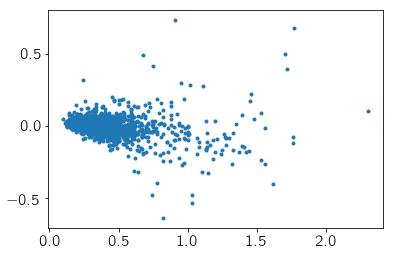

In [34]:
def halflight(reg, rer, rei, rez):
    m_g = 0.71 # slopes for halflight model
    m_r = 0.76
    m_i = 0.78
    m_z = 0.82

    b_g = 0.077 # y-intercepts for halflight model
    b_r = 0.072
    b_i = 0.069
    b_z = 0.068
    
    N = len(reg)

    W = np.ones(shape = (4,N))
    W[0] = reg
    W[1] = rer
    W[2] = rei
    W[3] = rez
    prox = np.median(W.T,1)

    W2 = np.zeros(N)     

    
    for ii in np.arange(N):
        
        if   np.abs(rez[ii]-prox[ii])<0.2: W2[ii] = m_z*rez[ii]+b_z
        elif np.abs(rei[ii]-prox[ii])<0.2: W2[ii] = m_i*rei[ii]+b_i
        elif np.abs(rer[ii]-prox[ii])<0.2: W2[ii] = m_r*rer[ii]+b_r
        elif np.abs(reg[ii]-prox[ii])<0.2: W2[ii] = m_g*reg[ii]+b_g
        else: W2[ii] = prox[ii]
    
    return W2
        


def ba(Sba):
    m_sba = 0.854 # slope for Wba vs Sba
    b_sba = 0.124 # y-intercept for Wba vs Sba
    print m_sba*Sba+b_sba


    
plt.plot(Re_w1,halflight(Re_g, Re_r, Re_i, Re_z)-Re_w1,'.')